In [1]:
import xarray as xa
import numpy as np
import scipy as sp
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import quasibi
import networkx
import glob

from datetime import datetime

import importlib
importlib.reload(quasibi);

In [2]:
d = xa.open_dataset("../data/data_downsampled_binned.nc").t2m

LAT, LON = np.load("../output/latlon_nodes.npz").values()

### Decadal Mean of Winter Temperature

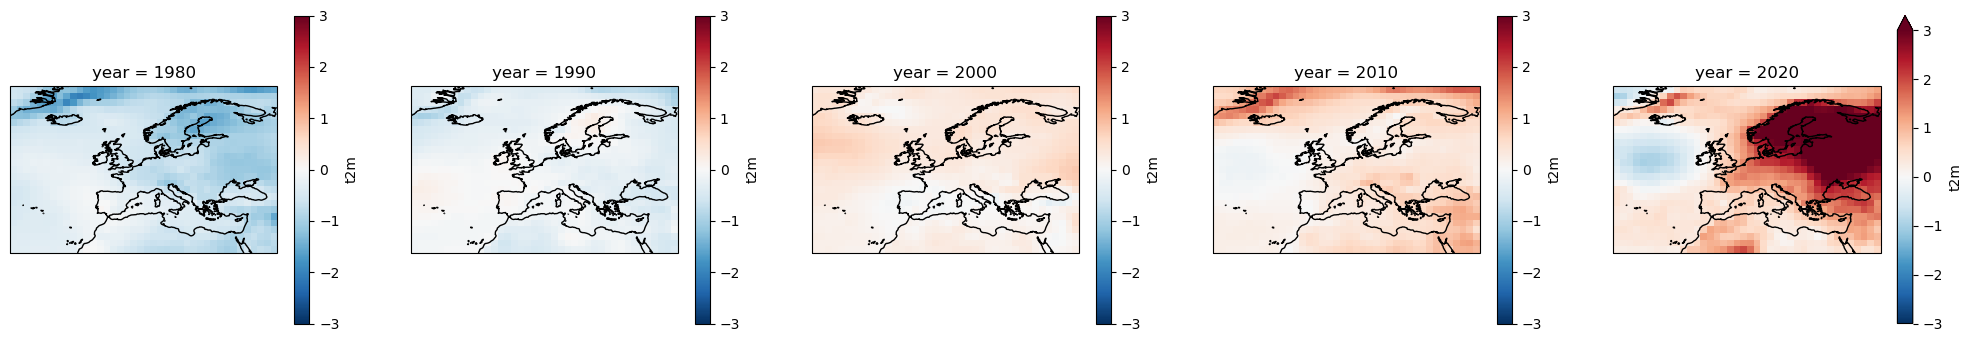

In [368]:
data = d.groupby(10*(d.time.dt.year // 10)).mean(dim="time") - d.mean(dim="time")

fig, axs = plt.subplots(1, 5, figsize=(25, 4), subplot_kw={"projection": ccrs.PlateCarree()})

for i, ax in enumerate(axs):
    data[i].plot(ax=ax, cmap="RdBu_r", vmin=-3, vmax=3)
    ax.coastlines()

### Yearly Mean of Winter Temperature

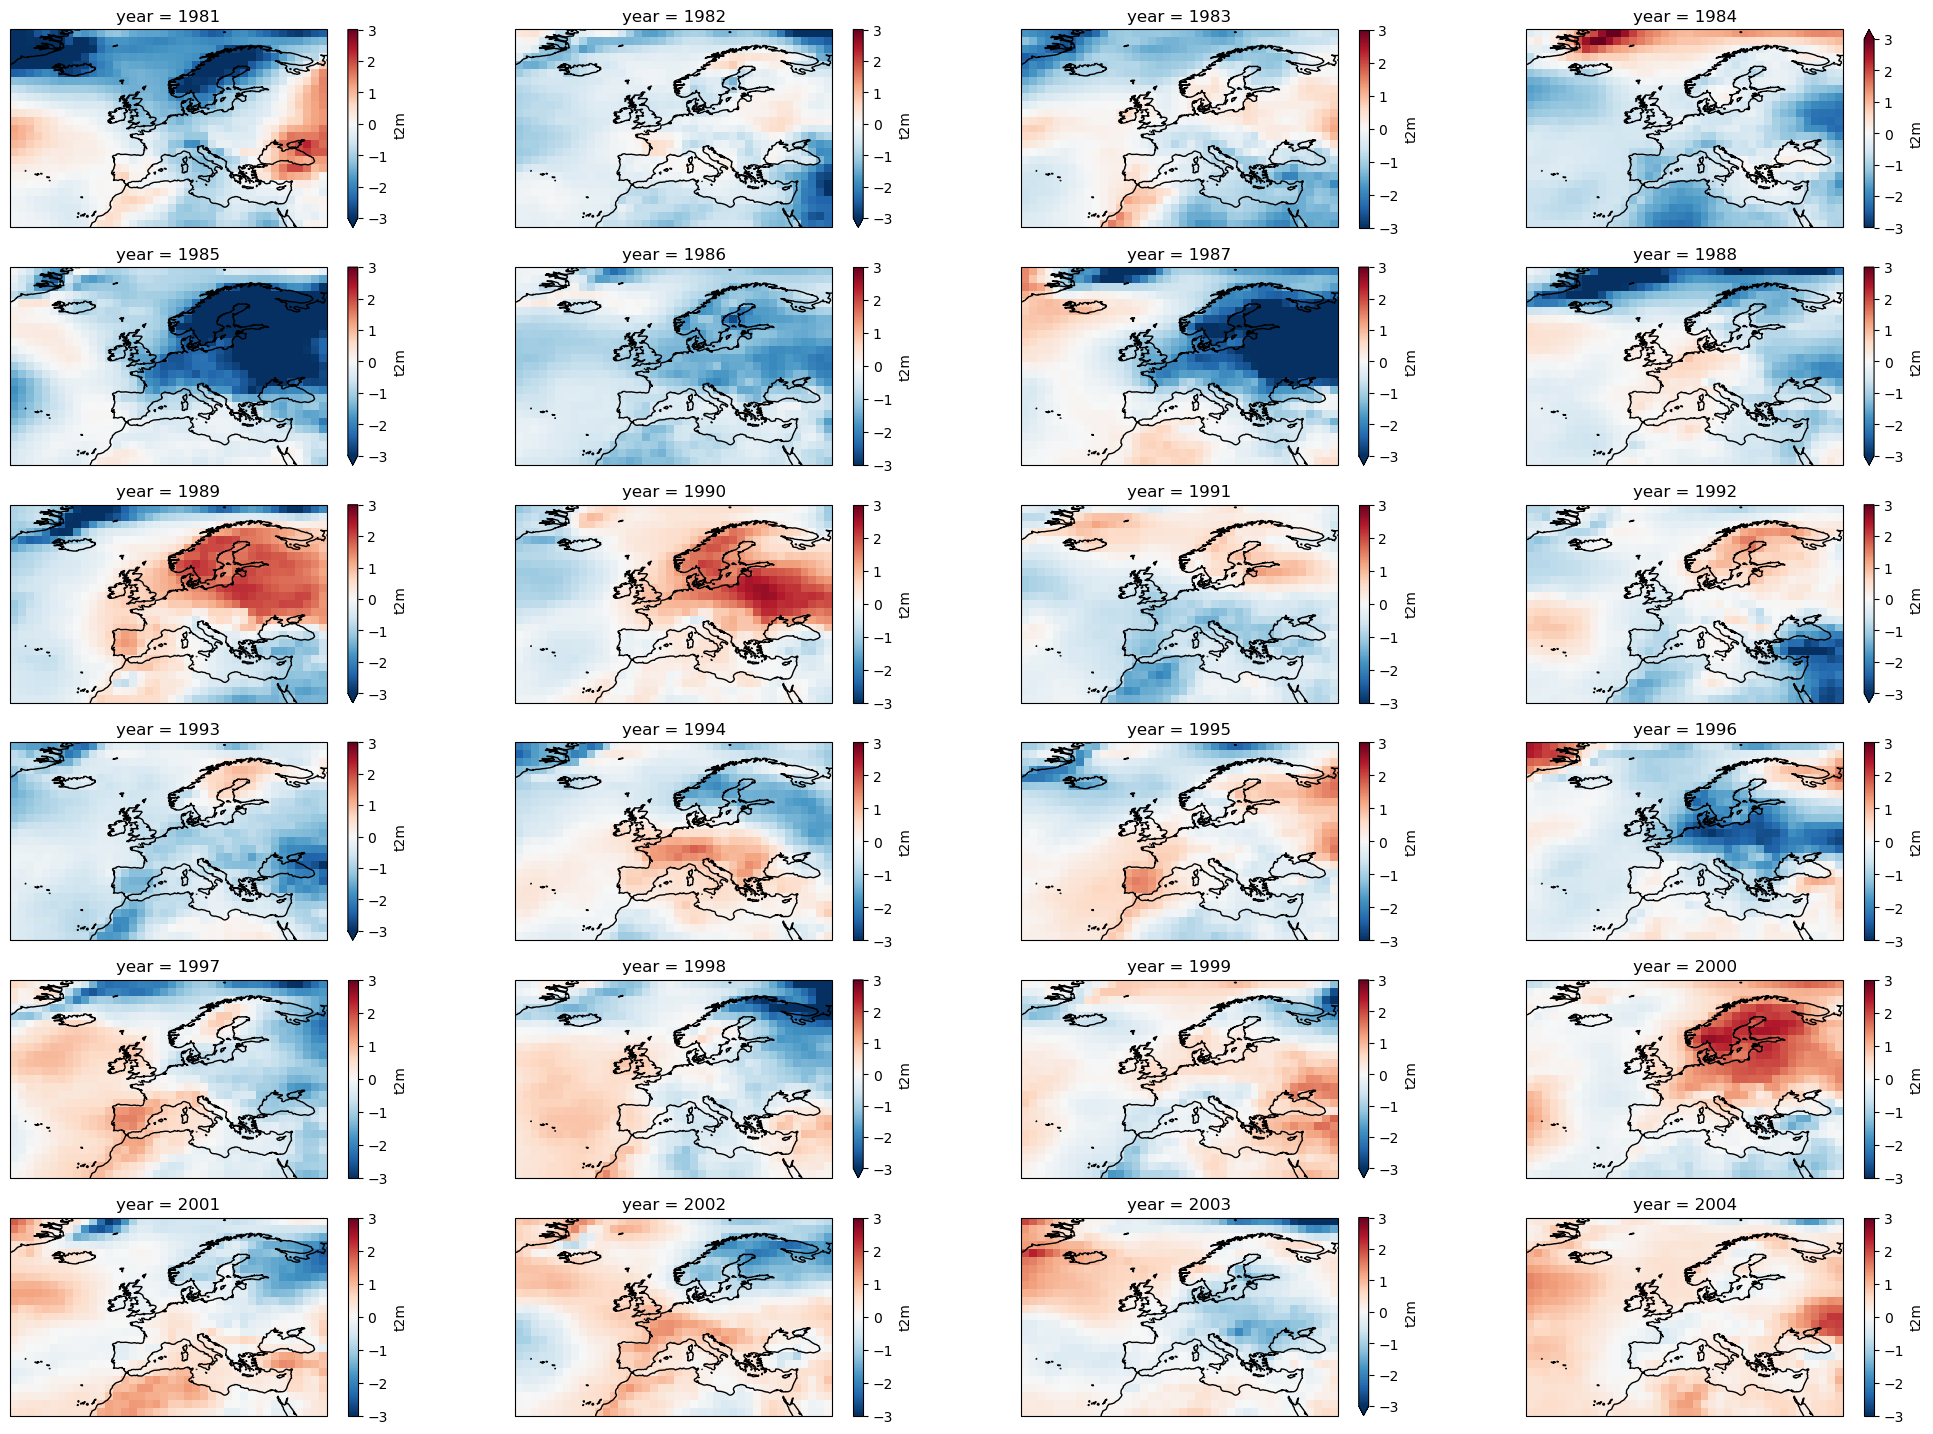

In [370]:
data = d.groupby(d.time.dt.year).mean(dim="time")
mean = d.mean(dim="time")

fig, axs = plt.subplots(6, 4, figsize=(25, 18), subplot_kw={"projection": ccrs.PlateCarree()})

for i, ax in enumerate(axs.flatten()):
    (data[i] - mean).plot(ax=ax, cmap="RdBu_r", vmin=-3, vmax=3)
    ax.coastlines()

### Detrended Daily Temperature and FFT

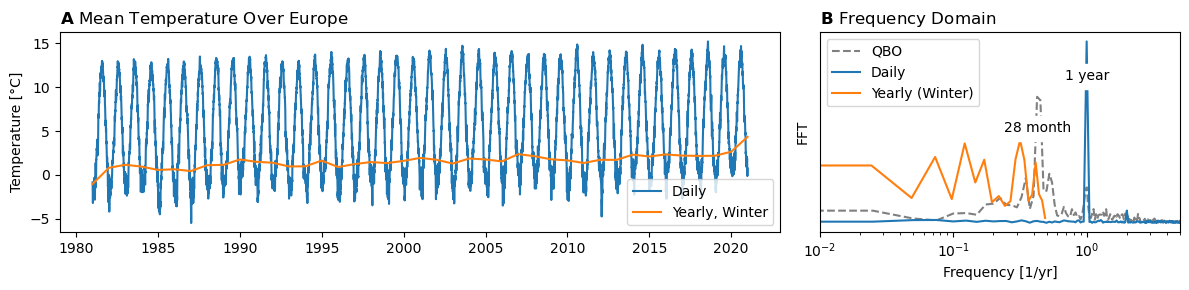

In [12]:
ds_daily = xa.open_dataset("../data/data_downsampled.nc").t2m.mean(dim=["latitude", "longitude"])

winter = ds_daily[(ds_daily.time.dt.month <= 3) | (ds_daily.time.dt.month >= 10)]
winter = winter.groupby(winter.time.dt.year - (winter.time.dt.month <= 3)).mean()

qbo = pd.read_fwf("../data/qbo.txt", skiprows=9, header=None, usecols=[1, 8], index_col=0)
qbo.index = [datetime(year=1953 + month//12, month=month%12 + 1, day=1) for month in range(len(qbo))]
qbo = qbo[(qbo.index.year >= 1981) & (qbo.index.year < 2021)]
qbo = sp.signal.detrend(qbo.to_numpy().flatten())
qbo = qbo/np.std(qbo)

fig, axs = plt.subplots(1, 2, figsize=(12, 3), gridspec_kw={"width_ratios": [2, 1]})

plt.subplot(121)
plt.plot(ds_daily.time, ds_daily - 278, label="Daily")
plt.plot(pd.date_range(start="1980", freq="1Y", periods=41), winter - 278, label="Yearly, Winter")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.title(r"$\bf{A}$ Mean Temperature Over Europe", loc="left")

ds_daily = sp.signal.detrend(ds_daily.to_numpy().flatten())
winter   = sp.signal.detrend(winter.to_numpy().flatten())

winter[0]  = 0
winter[-1] = 0

ds_daily = (ds_daily - ds_daily.mean())/ds_daily.std()
winter   = (winter - winter.mean())/winter.std()

plt.subplot(122)
plt.magnitude_spectrum(qbo, Fs=12, label="QBO", ls="--", c="gray")
plt.magnitude_spectrum(ds_daily, Fs=365, label="Daily")
plt.magnitude_spectrum(winter, Fs=1, label="Yearly (Winter)")

plt.semilogx()
plt.text(1, 0.55 ,"1 year", ha="center", backgroundcolor="white")
plt.text(12/28, 0.35 ,"28 month", ha="center", backgroundcolor="white")
plt.xlim([1e-2, 5e0])
plt.yticks([])
plt.ylabel("FFT")
plt.xlabel("Frequency [1/yr]")
plt.title(r"$\bf{B}$ Frequency Domain", loc="left")
plt.legend()

plt.tight_layout()
plt.savefig("../plots/timeseries.pdf", bbox_inches="tight")
plt.show()

### Detrended Yearly Temperature and FFT

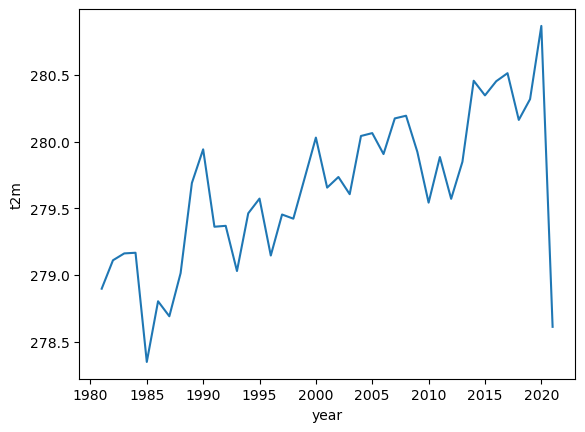

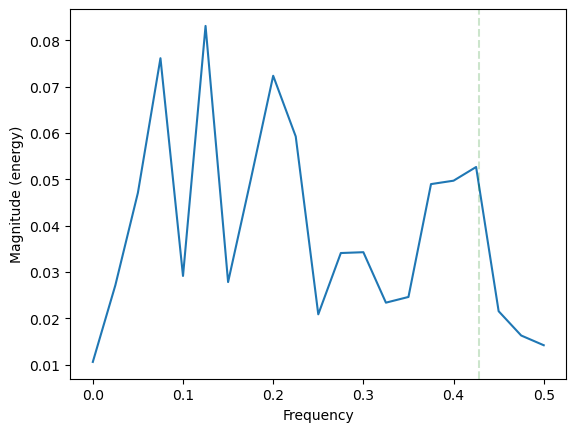

In [225]:
data = d.groupby(d.time.dt.year).mean(dim="time").mean(dim=["latitude", "longitude"])
data.plot()
plt.show()

data = sp.signal.detrend(data[:-1].to_numpy())
plt.magnitude_spectrum(data, Fs=1)
plt.axvline(12/28, c="green", ls="--", alpha=.2)
plt.show()

### Degree for the Static Network

In [4]:
pearson = quasibi.load_symmat("../output/rmd_correlation_matrix.npy")
pearson = np.abs(pearson) >= np.quantile(np.abs(pearson), 1 - 0.05)

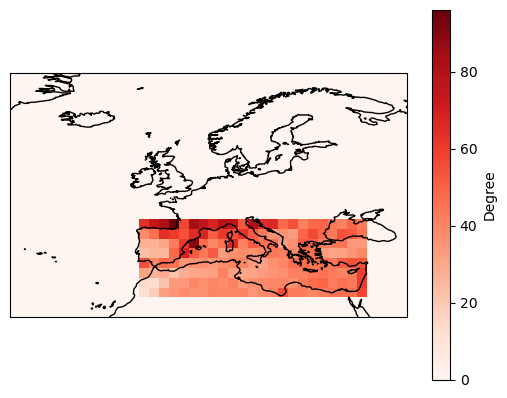

In [14]:
net = networkx.from_numpy_matrix(pearson)
deg = np.fromiter(dict(networkx.degree(net)).values(), "int").reshape((25, 40))

mask = np.zeros_like(deg)
mask[15:23,13:36] = 1

ax = plt.subplot(111, projection=ccrs.PlateCarree())
cmap = ax.imshow(mask*deg, extent=[LON.min(), LON.max(), LAT.min(), LAT.max(),], cmap="Reds")
plt.colorbar(cmap, label="Degree")

ax.coastlines()

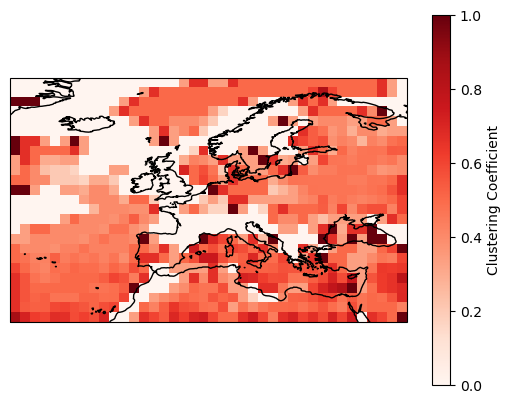

In [323]:
deg = quasibi.network_metric(pearson, quasibi.clustering_coefficient)

ax = plt.subplot(111, projection=ccrs.PlateCarree())
cmap = ax.imshow(deg, extent=[LON.min(), LON.max(), LAT.min(), LAT.max(),], cmap="Reds")
plt.colorbar(cmap, label="Clustering Coefficient")

ax.coastlines()

### Degree for Dynamic Network

In [77]:
pearson_files = np.array(np.sort(glob.glob("../output/dynamic/rmd_decadal*")))

0 ../output/dynamic\rmd_decadal_1980.npy
1 ../output/dynamic\rmd_decadal_1990.npy
2 ../output/dynamic\rmd_decadal_2000.npy
3 ../output/dynamic\rmd_decadal_2010.npy


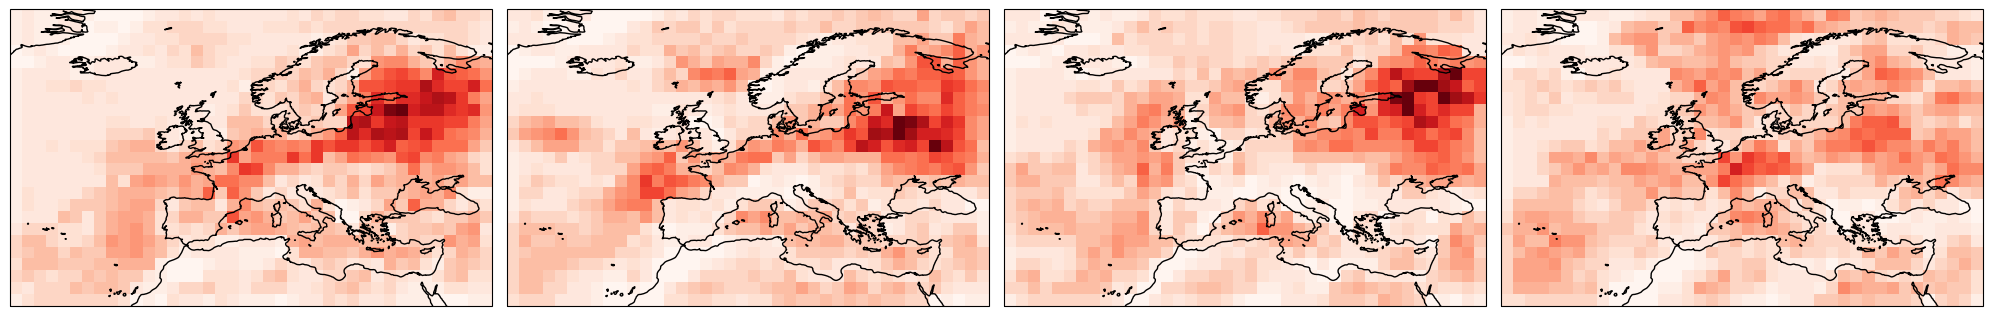

In [83]:
plt.figure(figsize=(25, 4))

for i, pearson_file in enumerate(pearson_files):
    print(i, pearson_file)
    
    pearson = quasibi.load_symmat(pearson_file)
    pearson = np.abs(pearson) >= np.quantile(np.abs(pearson), 0.995)
    
    net = networkx.from_numpy_matrix(pearson)
    deg = np.fromiter(dict(networkx.degree(net)).values(), "int").reshape((25, 40))

    ax = plt.subplot(151 + i, projection=ccrs.PlateCarree())
    cmap = ax.imshow(deg, extent=[LON.min(), LON.max(), LAT.min(), LAT.max(),], cmap="Reds", vmin=0, vmax=25)

    ax.coastlines()
    
plt.tight_layout()